In [1]:
%load_ext autoreload

In [ ]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from scipy.stats import bootstrap, mannwhitneyu, ttest_ind
from statsmodels.tsa.stattools import acf
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [ ]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [ ]:
# cfg.params.low_pass = 0.1
# cfg.params.high_pass = 4

# cfg.params.low_pass = 80
# cfg.params.high_pass = 30

cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

# cfg.params.stride = 120
# # cfg.params.window = 5
# cfg.params.window = 30

In [ ]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [ ]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]


In [ ]:
for data_class, agent in agent_data:
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        for dose in ['high', 'low']:
            if dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
                print(f"{agent} | {monkey} | {dose} | {len(agent_data[(data_class, agent)]['session_lists'][monkey][dose])}")

propofol | Mary | high | 10
propofol | MrJones | high | 11
ketamine | SPOCK | high | 8
ketamine | SPOCK | low | 0
ketamine | PEDRI | high | 8
ketamine | PEDRI | low | 0
dexmedetomidine | SPOCK | high | 8
dexmedetomidine | SPOCK | low | 0
dexmedetomidine | PEDRI | high | 8
dexmedetomidine | PEDRI | low | 0


In [ ]:
top_percent = 0.1
dose = 'high'
area = 'all'

In [ ]:
def get_num_crs(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).sum()
def get_num_crs_pos(delase_results, session, top_percent=0.1, area='all'):
    return delase_results[session][area].stability_params.apply(lambda x: len(x[:int(top_percent*len(x))][x[:int(top_percent*len(x))] >= 0])).sum()

In [ ]:
for (data_class, agent), data_dict in agent_data.items():
    print("--------------------------------")
    print(f"{agent}:")
    print("--------------------------------")
    unique_areas = np.unique(np.concatenate([list(d.keys()) for d in data_dict['delase_results'].values()]))
    delase_results = data_dict['delase_results']
    num_crs = {}
    num_crs_pos = {}
    for area in unique_areas:
        print(f"Area: {area}")
        print("---------")
        num_crs[area] = {}
        num_crs_pos[area] = {}
        for session in delase_results.keys():
            if area in delase_results[session].keys():
                num_crs[area][session] = get_num_crs(delase_results, session, top_percent, area)
                num_crs_pos[area][session] = get_num_crs_pos(delase_results, session, top_percent, area)
    
        total_crs = np.sum(list(num_crs[area].values()))
        total_crs_pos = np.sum(list(num_crs_pos[area].values()))
        total_crs_neg = total_crs - total_crs_pos
        print(f"Total CRs: {total_crs}")
        print(f"Positive CRs: {total_crs_pos} ({total_crs_pos/total_crs*100:.2f}%)")
        print(f"Negative CRs: {total_crs_neg} ({total_crs_neg/total_crs*100:.2f}%)")

--------------------------------
propofol:
--------------------------------
Area: all
---------
Total CRs: 1748991
Positive CRs: 27535 (1.57%)
Negative CRs: 1721456 (98.43%)
--------------------------------
ketamine:
--------------------------------
Area: all
---------
Total CRs: 1700419
Positive CRs: 1225 (0.07%)
Negative CRs: 1699194 (99.93%)
--------------------------------
dexmedetomidine:
--------------------------------
Area: all
---------
Total CRs: 1952298
Positive CRs: 9937 (0.51%)
Negative CRs: 1942361 (99.49%)


# Aggregate Plots

In [77]:
# plot_data = {}
# for (data_class, agent), data_dict in agent_data.items():
#     # area = 'vlPFC' if agent == 'propofol' else 'vlPFC-L'
#     # area = 'FEF' if agent == 'propofol' else 'vlPFC-R'
#     # area = '7b' if agent == 'propofol' else 'dlPFC-R'
#     # area = 'CPB' if agent == 'propofol' else 'dlPFC-L'
#     if agent == 'propofol':
#         plot_range = (-15, 85)
#     elif agent == 'ketamine':
#         plot_range = (-30, 220)
#     else:
#         plot_range = (-30, 180)
#     if dose == 'high':
#         save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
#     else:
#         save_path = os.path.join(img_save_dir, f"{agent}_timescales_grouped_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
#     cfg.params.data_class = data_class
#     plot_data[(data_class, agent)] = plot_session_stability_grouped(
#         cfg, 
#         agent, 
#         data_dict['session_lists'], 
#         data_dict['delase_results'], 
#         data_dict['locs'], 
#         data_dict['rocs'], 
#         data_dict['ropaps'],
#         timescales=True,
#         plot_range=plot_range, 
#         top_percent=top_percent, 
#         curve_colors=curve_colors, 
#         loc_roc_colors=loc_roc_colors, 
#         figsize=(4, 2),
#         dose=dose,
#         save_path=save_path,
#         verbose=True,
#         area=area,
#         return_data=True
#     )


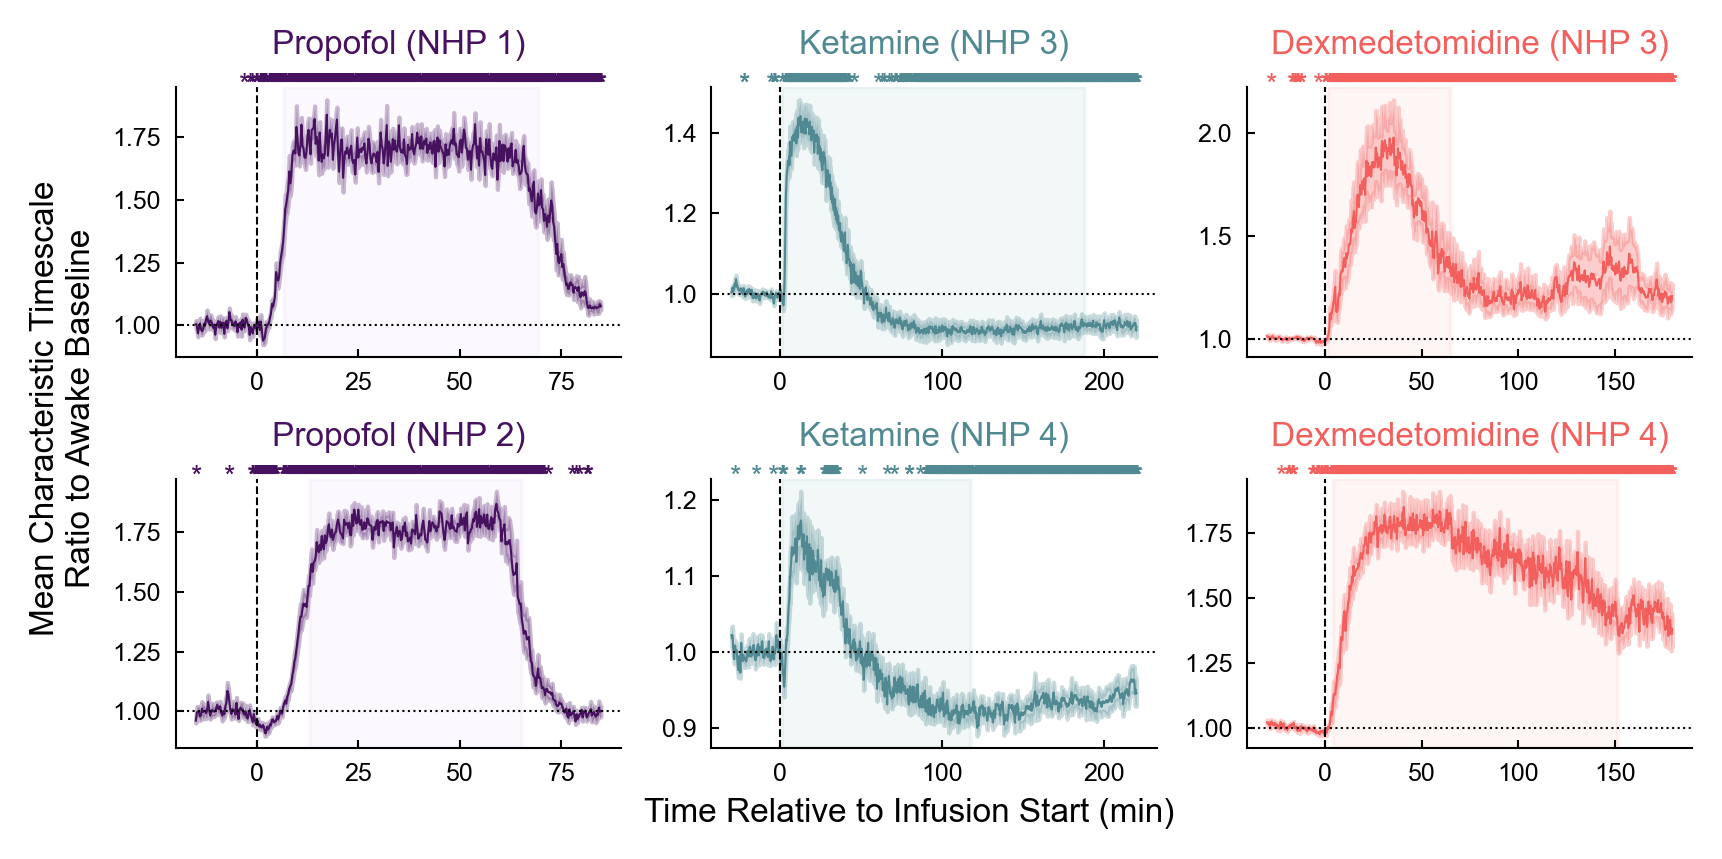

In [18]:
# Grid version of plot_session_stability_grouped
plot_range_by_agent = {
    'propofol': (-15, 85),
    'ketamine': (-30, 220),
    'dexmedetomidine': (-30, 180)
}

area = 'all'

if dose == 'high':
    grid_save_path = os.path.join(img_save_dir, f"stability_grouped_grid_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
else:
    grid_save_path = os.path.join(img_save_dir, f"stability_grouped_grid_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")

grid_plot_data = plot_session_stability_grouped_grid(
    cfg=cfg,
    agent_data=agent_data,            # dict keyed by (data_class, agent)
    data_class=None,                  # or a single class for all
    data_class_by_agent=None,         # or dict agent -> data_class
    top_percent=top_percent,
    timescales=True,
    curve_colors=curve_colors,
    loc_roc_colors=loc_roc_colors,
    dose=dose,
    save_path=grid_save_path,
    verbose=True,
    area=area,
    area_by_agent=None,               # or dict agent -> area
    plot_range_by_agent=plot_range_by_agent,
    return_data=True,
    data_type='delase',
    star_height_base=0.95,
    layout='nhp_rows',
    figsize=(6, 3),
    # layout='agent_rows',
    # figsize=(5, 6),
)


propofol high unconscious-awake: 0.0009765625
propofol high unconscious-awake: 0.00048828125
ketamine high unconscious-awake: 0.00390625
ketamine high recovery-awake: 0.01171875
ketamine high unconscious-awake: 0.0390625
ketamine high recovery-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625


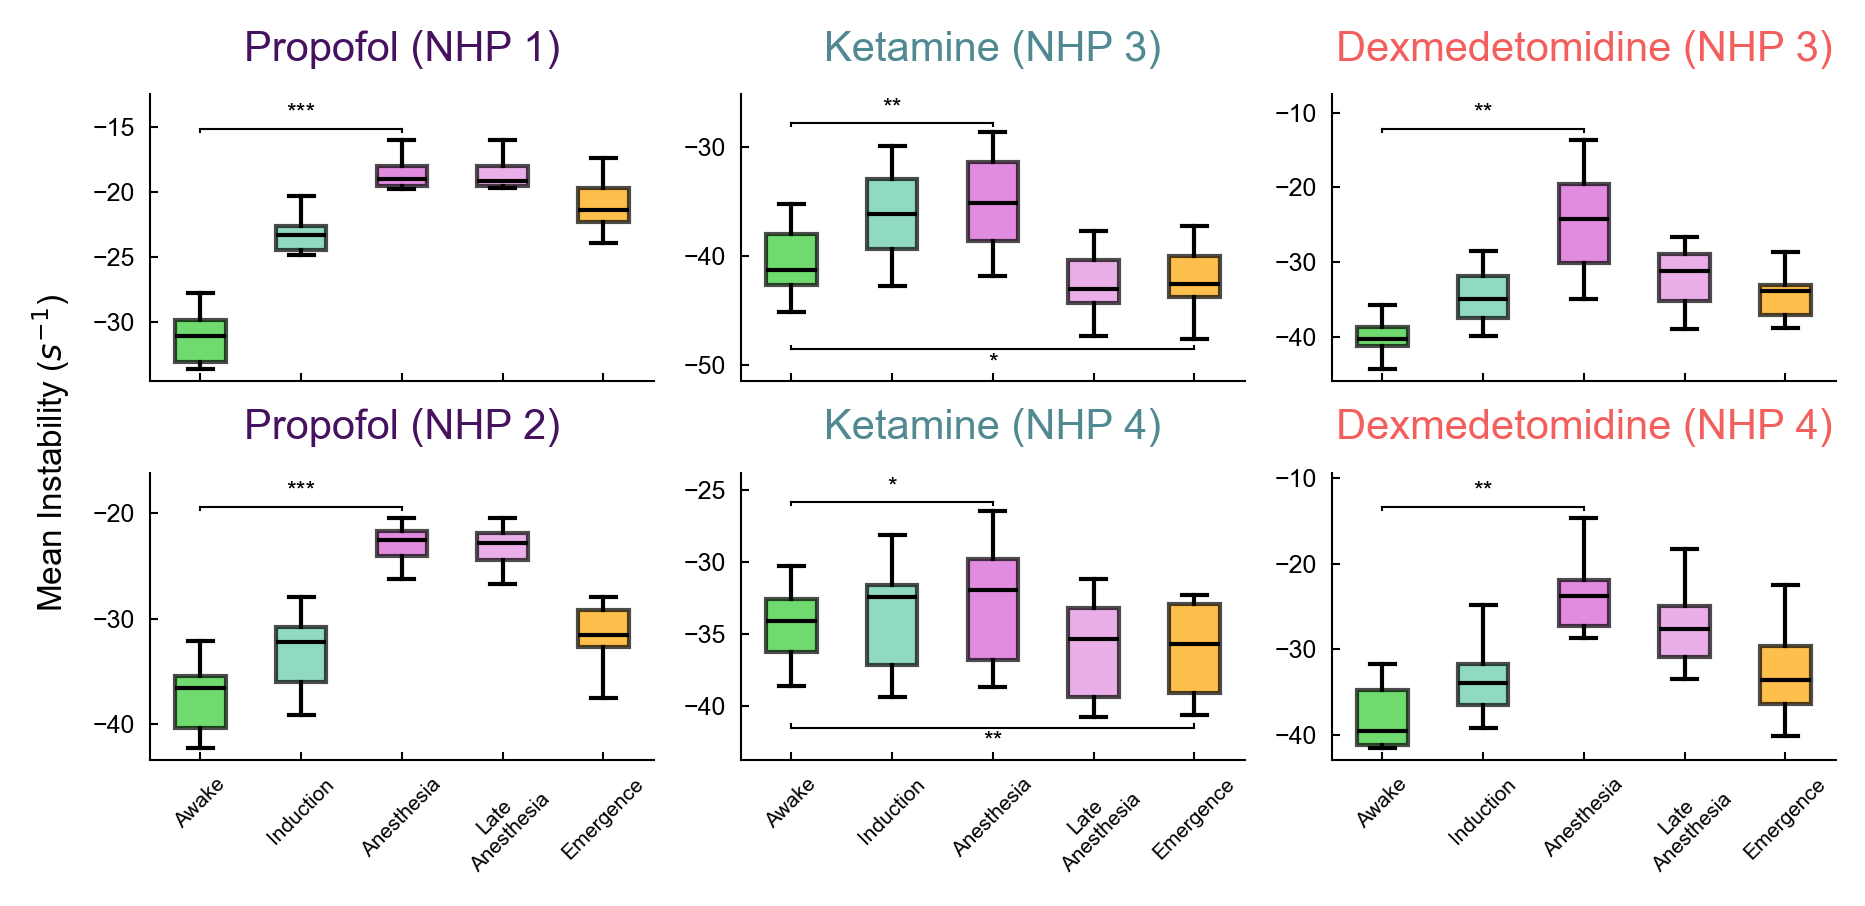

In [11]:
top_percent = 0.1
area = 'all'

# Prepare results_by_agent dict for grid function
results_by_agent = {}
for (data_class, agent), data_dict in agent_data.items():
    results_by_agent[(data_class, agent)] = data_dict['delase_results']

# Create single grid save path
if dose == 'high':
    grid_save_path = os.path.join(img_save_dir, f"section_stability_boxes_grid_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
else:
    grid_save_path = os.path.join(img_save_dir, f"section_stability_boxes_grid_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")

# Use grid function to plot all agents on a single grid
grid_section_means = plot_section_stability_boxes_grid(
    cfg=cfg,
    agent_data=agent_data,
    results_by_agent=results_by_agent,
    top_percent=top_percent,
    curve_colors=curve_colors,
    # figsize=(5, 6),
    # layout='agent_rows',
    figsize=(6, 3),
    layout='nhp_rows',
    dose=dose,
    save_path=grid_save_path,
    section_info_type='plot',
    verbose=False,
    area=area,
    sharex=True
)

# Convert grid return format to match original format: section_means[(data_class, agent)]
section_means = {}
for (data_class, agent) in agent_data.keys():
    if agent in grid_section_means:
        section_means[(data_class, agent)] = grid_section_means[agent]

propofol high unconscious-awake: 0.0009765625
propofol high unconscious-awake: 0.00048828125
ketamine high unconscious-awake: 0.00390625
ketamine high recovery-awake: 0.01171875
ketamine high unconscious-awake: 0.0390625
ketamine high recovery-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625
dexmedetomidine high unconscious-awake: 0.00390625


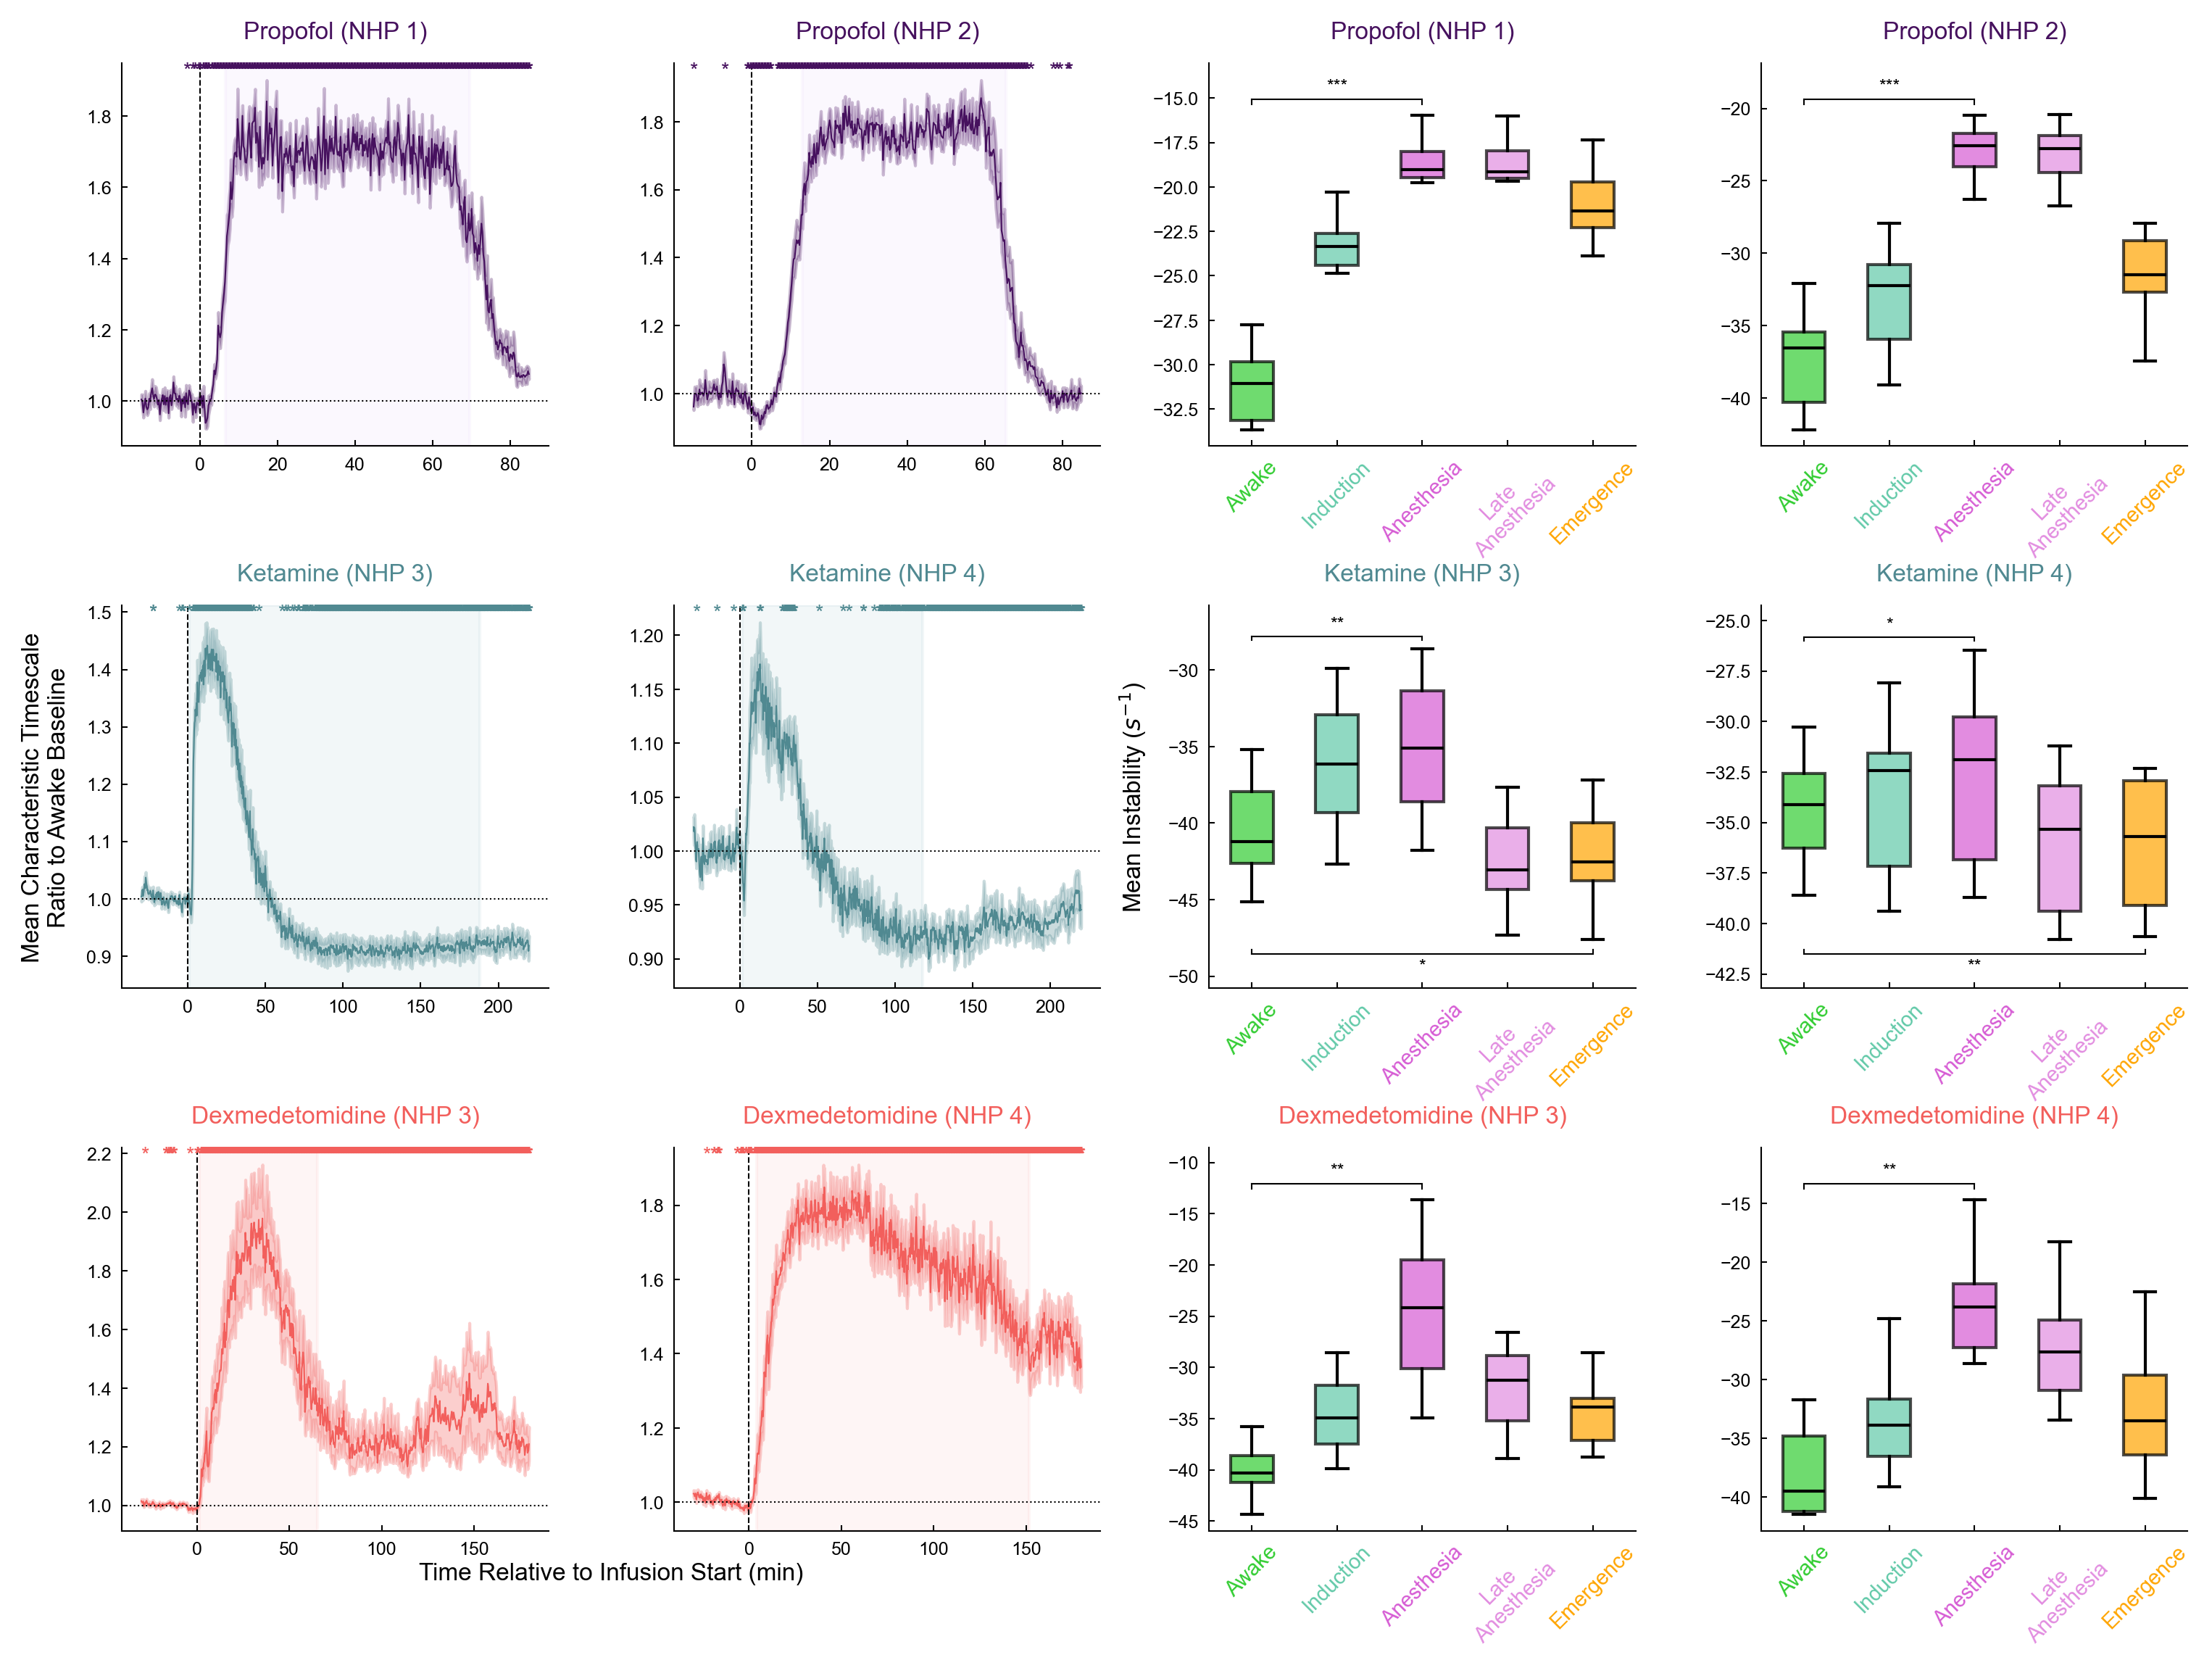

In [16]:
# Combined plot: Grouped stability + Section stability in a 3x4 grid
top_percent = 0.1
area = 'all'

# Prepare results_by_agent dict for combined function
results_by_agent = {}
for (data_class, agent), data_dict in agent_data.items():
    results_by_agent[(data_class, agent)] = data_dict['delase_results']

# Plot range by agent
plot_range_by_agent = {
    'propofol': (-15, 85),
    'ketamine': (-30, 220),
    'dexmedetomidine': (-30, 180)
}

# Create combined grid save path
if dose == 'high':
    combined_save_path = os.path.join(img_save_dir, f"combined_stability_grid_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")
else:
    combined_save_path = os.path.join(img_save_dir, f"combined_stability_grid_low_dose_filter_{cfg.params.low_pass}_{cfg.params.high_pass}_{area}_window_{cfg.params.window}_stride_{cfg.params.stride}.pdf")

# Use combined function to plot both grouped and section stability on a single 3x4 grid
combined_plot_data = plot_combined_stability_grid(
    cfg=cfg,
    agent_data=agent_data,
    results_by_agent=results_by_agent,
    top_percent=top_percent,
    timescales=True,
    curve_colors=curve_colors,
    loc_roc_colors=loc_roc_colors,
    # figsize=(12, 9),
    figsize=(10, 7.5),
    dose=dose,
    save_path=combined_save_path,
    section_info_type='plot',
    verbose=False,
    area=area,
    plot_range_by_agent=plot_range_by_agent,
    return_data=True,
    data_type='delase',
    star_height_base=0.95
)


In [38]:
# ketamine recovery both monkeys
all_sessions_both = {}
for d in [section_means[('anesthesiaLvrOdd', 'ketamine')][monkey]['high'] for monkey in section_means[('anesthesiaLvrOdd', 'ketamine')].keys()]:
    all_sessions_both.update(d)

In [39]:
emergence_vals = [all_sessions_both[session]['Emergence'] for session in all_sessions_both.keys()]
awake_vals = [all_sessions_both[session]['Awake'] for session in all_sessions_both.keys()]

In [40]:
wilcoxon(emergence_vals, awake_vals, alternative='less')

WilcoxonResult(statistic=np.float64(6.0), pvalue=np.float64(0.000213623046875))

# Statistics

### Mean Instability Values Across Animals and Sections

In [41]:
mean_values = {}
infusion_starts = {}
top_percents = np.arange(0.01, 0.305, 0.01)
# top_percents = np.arange(0.02, 1.01, 0.02)
top_percents[np.argmin(np.abs(top_percents - 0.1))] = 0.1
for data_class, agent in anesthetic_agent_list:
    mean_values[(data_class, agent)] = {}
    infusion_starts[(data_class, agent)] = {}
    cfg.params.data_class = data_class
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        sessions_to_use = agent_data[(data_class, agent)]['session_lists'][monkey]['high']
        mean_values[(data_class, agent)][monkey] = {}
        infusion_starts[(data_class, agent)][monkey] = {}
        for session in tqdm(sessions_to_use, desc=f'{agent} | {monkey}'):
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']
            section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
            mean_values[(data_class, agent)][monkey][session] = {}
            infusion_starts[(data_class, agent)][monkey][session] = infusion_start
            for top_percent in top_percents:
                mean_values[(data_class, agent)][monkey][session][top_percent] = {}
                for section in ['Awake', 'Anesthesia', 'Emergence']:
                    times_tup = section_info[np.where([tup[0] == section for tup in section_info])[0][0]][1]
                    df_window_starts_rel_minutes = (df.window_start - infusion_start)/60
                    mean_values[(data_class, agent)][monkey][session][top_percent][section] = df[(df_window_starts_rel_minutes >= times_tup[0]) & (df_window_starts_rel_minutes <= times_tup[1])].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).mean()

propofol | Mary:   0%|          | 0/10 [00:00<?, ?it/s]

propofol | MrJones:   0%|          | 0/11 [00:00<?, ?it/s]

ketamine | SPOCK:   0%|          | 0/8 [00:00<?, ?it/s]

ketamine | PEDRI:   0%|          | 0/8 [00:00<?, ?it/s]

dexmedetomidine | SPOCK:   0%|          | 0/8 [00:00<?, ?it/s]

dexmedetomidine | PEDRI:   0%|          | 0/8 [00:00<?, ?it/s]

In [42]:
# MEAN AWAKE VALUES

monkey_awake_vals = {
    'Mary': [],
    'MrJones': [],
    'SPOCK': [],
    'PEDRI': []
}
top_percent = 0.1
for data_class, agent in anesthetic_agent_list:
    for monkey in mean_values[(data_class, agent)]:
        monkey_awake_vals[monkey].extend([mean_values[(data_class, agent)][monkey][session][top_percent]['Awake'] for session in mean_values[(data_class, agent)][monkey]])

for monkey in monkey_awake_vals:
    print(f"{monkey} | {np.mean(monkey_awake_vals[monkey])} (+/- {np.std(monkey_awake_vals[monkey])/np.sqrt(len(monkey_awake_vals[monkey]))})")


Mary | -31.24614906311035 (+/- 0.5915995136112009)
MrJones | -37.5583381652832 (+/- 0.9573607578521236)
SPOCK | -40.20906448364258 (+/- 0.7602911591529846)
PEDRI | -36.14795684814453 (+/- 0.9234187602996826)


In [43]:
def hodges_lehmann_estimator(differences):
    """
    Compute the Hodges-Lehmann estimator for the difference between two paired samples.
    The estimator is the median of all pairwise differences (epoch1 - epoch2).
    """
    # For paired samples, the HL estimator is just the median of paired differences
    return np.median(differences)


def compute_wilcoxon_and_median_diff(epoch1_vals, epoch2_vals, alternative='two-sided'):
    differences = epoch2_vals - epoch1_vals
    median_diff = hodges_lehmann_estimator(differences)
    wilcoxon_p_value = wilcoxon(epoch1_vals, epoch2_vals, alternative=alternative).pvalue

    bootstrap_ci = stats.bootstrap(
        (differences,),                # Your data (as a tuple)
        hodges_lehmann_estimator,                     # The statistic to compute
        confidence_level=0.95,         # Your desired CI
        method='percentile',           # Standard percentile method
        n_resamples=10000               # Number of bootstrap samples
    )

    ci = (bootstrap_ci.confidence_interval.low, bootstrap_ci.confidence_interval.high)

    return median_diff, wilcoxon_p_value, ci

def power_analysis(epoch1_vals, epoch2_vals, alternative='two-sided'):
    # 2. --- Calculate the observed differences ---
    # This is our "population" for the simulation
    differences = np.array(epoch2_vals) - np.array(epoch1_vals)

    # Set the number of simulations
    n_simulations = 10000
    n_significant = 0

    # 3. --- Run the simulation loop ---
    for _ in range(n_simulations):
        # 'Resample with replacement' from your observed differences
        # This simulates a new "experiment"
        resampled_diffs = np.random.choice(
            differences, 
            size=len(differences), 
            replace=True
        )
        
        # Run the Wilcoxon test on the new simulated sample
        # We must handle the case where all differences are zero (rare)
        if np.all(resampled_diffs == 0):
            continue
            
        # We're testing if the median is different from zero
        # Negate the differences because typically epoch1_vals - epoch2_vals
        w, p_value = stats.wilcoxon(-resampled_diffs, alternative=alternative)
        
        # Count if the simulated experiment was "significant"
        if p_value < 0.05:
            n_significant += 1

    # 4. --- Calculate the "post-hoc power" ---
    observed_power = n_significant / n_simulations

    return observed_power


all_section_means = {}
for data_class, agent in anesthetic_agent_list:
    all_section_means[(data_class, agent)] = {}
    for monkey in mean_values[(data_class, agent)]:
        print("="*50)
        print(f"{agent} | {monkey}")
        print("="*50)
        all_section_means[(data_class, agent)][monkey] = {}
        for top_percent in top_percents:

            all_section_means[(data_class, agent)][monkey][top_percent] = {}
            for section in ['Awake', 'Anesthesia', 'Emergence']:
                section_means = [mean_values[(data_class, agent)][monkey][session][top_percent][section] for session in mean_values[(data_class, agent)][monkey]]
                # print(f"{agent} | {monkey} | {section} | {np.mean(section_means)} (+/- {np.std(section_means)/np.sqrt(len(section_means))})")
                all_section_means[(data_class, agent)][monkey][top_percent][section] = section_means


            if top_percent == 0.1:
                print(f"-"*10)
                print(f"Top {top_percent*100:.0f}% of Instability")
                print(f"-"*10)
                awake_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Awake'])
                anesthesia_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia'])
                emergence_means = np.array(all_section_means[(data_class, agent)][monkey][top_percent]['Emergence'])

                median_diff_anesthesia_awake, wilcoxon_p_value_anesthesia_awake, ci_anesthesia_awake = compute_wilcoxon_and_median_diff(awake_means, anesthesia_means, alternative='less')
                if agent == 'ketamine':
                    alternative = 'greater'
                    print(anesthesia_means - awake_means)                
                else:
                    alternative = 'less'
                median_diff_emergence_awake, wilcoxon_p_value_emergence_awake, ci_emergence_awake = compute_wilcoxon_and_median_diff(awake_means, emergence_means, alternative=alternative)
                
                print(f"Anesthesia v Awake")
                print(f"P-value: {wilcoxon_p_value_anesthesia_awake:.3f}, Median Difference: {median_diff_anesthesia_awake:.3f}, 95% CI: [{ci_anesthesia_awake[0]:.3f}, {ci_anesthesia_awake[1]:.3f}]")
                print(f"Emergence v Awake")
                print(f"P-value: {wilcoxon_p_value_emergence_awake:.3f}, Median Difference: {median_diff_emergence_awake:.3f}, 95% CI: [{ci_emergence_awake[0]:.3f}, {ci_emergence_awake[1]:.3f}]")
                print("\n")

                print(f"Power Analysis")
                print(f"Anesthesia v Awake: {power_analysis(awake_means, anesthesia_means, alternative='less'):.3f}")
                print(f"Emergence v Awake: {power_analysis(awake_means, emergence_means, alternative=alternative):.3f}")
                print("\n")


propofol | Mary
----------
Top 10% of Instability
----------
Anesthesia v Awake
P-value: 0.001, Median Difference: 12.970, 95% CI: [11.657, 13.649]
Emergence v Awake
P-value: 0.001, Median Difference: 10.291, 95% CI: [8.799, 11.606]


Power Analysis
Anesthesia v Awake: 1.000
Emergence v Awake: 1.000


propofol | MrJones
----------
Top 10% of Instability
----------
Anesthesia v Awake
P-value: 0.000, Median Difference: 14.285, 95% CI: [13.557, 16.512]
Emergence v Awake
P-value: 0.000, Median Difference: 6.144, 95% CI: [4.124, 7.859]


Power Analysis
Anesthesia v Awake: 1.000
Emergence v Awake: 1.000


ketamine | SPOCK
----------
Top 10% of Instability
----------
[6.66399   5.8562965 6.0928993 2.7236328 6.9121685 5.4072666 3.3653069
 6.412197 ]
Anesthesia v Awake
P-value: 0.004, Median Difference: 5.975, 95% CI: [3.365, 6.664]
Emergence v Awake
P-value: 0.012, Median Difference: -2.095, 95% CI: [-3.114, -0.844]


Power Analysis
Anesthesia v Awake: 1.000
Emergence v Awake: 0.889


ketamine

In [ ]:
# COMBINED MODELS
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

statistical_info = {}

top_percent = 0.1

for data_class, agent in anesthetic_agent_list:
    statistical_info[(data_class, agent)] = {}
    for monkey in all_section_means[(data_class, agent)]:
        statistical_info[(data_class, agent)][monkey] = {}
        
        awake_means = all_section_means[(data_class, agent)][monkey][top_percent]['Awake']
        anesthesia_means = all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia']
        emergence_means = all_section_means[(data_class, agent)][monkey][top_percent]['Emergence']

        # Create the data
        data = {
            'session': np.concatenate(([f"S{i+1}" for i in np.arange(len(awake_means))], [f"S{i+1}" for i in np.arange(len(anesthesia_means))], [f"S{i+1}" for i in np.arange(len(emergence_means))])),
            'session_order': np.concatenate((np.arange(len(awake_means)), np.arange(len(anesthesia_means)), np.arange(len(emergence_means)))),
            'state':  ['Awake']*len(awake_means) + ['Anesthesia']*len(anesthesia_means) + ['Emergence']*len(emergence_means),
            'instability': np.concatenate((awake_means, anesthesia_means, emergence_means))
        }
        df = pd.DataFrame(data)
        statistical_info[(data_class, agent)][monkey]['df'] = df
    
        # --- Define Formulas ---
        # Explicitly setting 'Awake' as the reference for all models
        BASE_STATE_FORMULA = "instability ~ C(state, Treatment(reference='Awake'))"
        # Formula 1: Simple OLS
        FORMULA_OLS = BASE_STATE_FORMULA
        # Formula 2: LMEM (Clustering Control)
        FORMULA_LMEM = BASE_STATE_FORMULA
        # Formula 3: Sequential LMEM (Clustering + Carry-over Control)
        FORMULA_SEQUENTIAL = f"{BASE_STATE_FORMULA} + session_order"
        
        model_simple_ml = smf.ols(FORMULA_OLS, data=df).fit(reml=False)
        model_lmem_ml = smf.mixedlm(FORMULA_LMEM, data=df, groups=df["session"]).fit(reml=False)

        statistical_info[(data_class, agent)][monkey]['model_simple_ml'] = model_simple_ml
        statistical_info[(data_class, agent)][monkey]['model_lmem_ml'] = model_lmem_ml

        LRT_stat_clust = 2 * (model_lmem_ml.llf - model_simple_ml.llf)
        p_value_clust = chi2.sf(LRT_stat_clust, 1)

        statistical_info[(data_class, agent)][monkey]['LRT_stat_clust'] = LRT_stat_clust
        statistical_info[(data_class, agent)][monkey]['p_value_clust'] = p_value_clust

        model_sequential_ml = smf.mixedlm(
            FORMULA_SEQUENTIAL, 
            data=df, 
            groups=df["session"]
        ).fit(reml=False)

        LRT_stat_seq = 2 * (model_sequential_ml.llf - model_lmem_ml.llf)
        p_value_seq = chi2.sf(LRT_stat_seq, 1) 

        statistical_info[(data_class, agent)][monkey]['LRT_stat_seq'] = LRT_stat_seq
        statistical_info[(data_class, agent)][monkey]['p_value_seq'] = p_value_seq
        
        Final_Formula = FORMULA_LMEM
        if p_value_seq < 0.05:
            Final_Formula = FORMULA_SEQUENTIAL


        model_final_reml = smf.mixedlm(
            Final_Formula, 
            data=df, 
            groups=df["session"],
        ).fit(reml=True)

        # Calculate Intraclass Correlation Coefficient (ICC)
        variance_residual = model_final_reml.scale
        variance_session = model_final_reml.cov_re.iloc[0, 0] # Random intercept variance
        icc = variance_session / (variance_session + variance_residual)

        # Extract fixed effects: Intercept (index 0), Anesthesia (index 1), Emergence (index 2)
        # If sequential effect is included, it is index 3.
        fixed_effects = model_final_reml.params
        p_values = model_final_reml.pvalues
        labels = model_final_reml.params.index

        # Anesthesia vs. Awake (Index 1)
        statistical_info[(data_class, agent)][monkey]['anesthesia_coeff'] = fixed_effects.iloc[1]
        statistical_info[(data_class, agent)][monkey]['anesthesia_pvalue'] = p_values.iloc[1]
        statistical_info[(data_class, agent)][monkey]['anesthesia_label'] = labels[1]
        statistical_info[(data_class, agent)][monkey]['emergence_coeff'] = fixed_effects.iloc[2]
        statistical_info[(data_class, agent)][monkey]['emergence_pvalue'] = p_values.iloc[2]
        statistical_info[(data_class, agent)][monkey]['emergence_label'] = labels[2]

        if 'session_order' in labels:
            # Session Order (Index 3 if present)
            order_idx = labels.get_loc('session_order')
            statistical_info[(data_class, agent)][monkey]['order_coeff'] = fixed_effects.iloc[order_idx]
            statistical_info[(data_class, agent)][monkey]['order_pvalue'] = p_values.iloc[order_idx]
        else:
            # compute it anyway
            model_seq_reml = smf.mixedlm(
                FORMULA_SEQUENTIAL, 
                data=df, 
                groups=df["session"],
            ).fit(reml=True)
            fixed_effects = model_seq_reml.params
            p_values = model_seq_reml.pvalues
            labels = model_seq_reml.params.index
            order_idx = labels.get_loc('session_order')
            statistical_info[(data_class, agent)][monkey]['order_coeff'] = fixed_effects.iloc[order_idx]
            statistical_info[(data_class, agent)][monkey]['order_pvalue'] = p_values.iloc[order_idx]
            


In [45]:
for data_class, agent in statistical_info:
    for monkey in statistical_info[(data_class, agent)]:
        print("="*50)
        print(f"Agent: {agent}, Monkey: {monkey}")
        print("="*30)
        print(f"Anesthesia Coeff: {statistical_info[(data_class, agent)][monkey]['anesthesia_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['anesthesia_pvalue']}")
        print(f"Emergence Coeff: {statistical_info[(data_class, agent)][monkey]['emergence_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['emergence_pvalue']}")
        print(f"Seq model p-value: {statistical_info[(data_class, agent)][monkey]['p_value_seq']}")
        # if statistical_info[(data_class, agent)][monkey]['p_value_seq'] < 0.05:
        #     print(f"Order Coeff: {statistical_info[(data_class, agent)][monkey]['order_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['order_pvalue']}")
        print(f"Order Coeff: {statistical_info[(data_class, agent)][monkey]['order_coeff']}, P-value: {statistical_info[(data_class, agent)][monkey]['order_pvalue']}")

Agent: propofol, Monkey: Mary
Anesthesia Coeff: 12.700563144683835, P-value: 4.384943112193714e-237
Emergence Coeff: 10.22627143859863, P-value: 1.9516899154312532e-154
Seq model p-value: 0.5659781824501648
Order Coeff: 0.09651340715813435, P-value: 0.6046949477655059
Agent: propofol, Monkey: MrJones
Anesthesia Coeff: 14.63182900168679, P-value: 4.321447698975991e-113
Emergence Coeff: 6.0940791043368225, P-value: 4.8294493177815696e-21
Seq model p-value: 0.7574792585803424
Order Coeff: 0.06772289854107182, P-value: 0.7795386703132863
Agent: ketamine, Monkey: SPOCK
Anesthesia Coeff: 5.429219722747802, P-value: 1.9055164726183366e-13
Emergence Coeff: -1.8240370750427255, P-value: 0.013468930496567956
Seq model p-value: 0.37727905043670107
Order Coeff: -0.4830234012906537, P-value: 0.4332305009905504
Agent: ketamine, Monkey: PEDRI
Anesthesia Coeff: 1.5967693328857417, P-value: 0.0018589311608531189
Emergence Coeff: -1.5793752670288088, P-value: 0.0020840030767182746
Seq model p-value: 0.4

In [46]:
wilcoxon_p_values = {}
for data_class, agent in anesthetic_agent_list:
    wilcoxon_p_values[(data_class, agent)] = {}
    for monkey in all_section_means[(data_class, agent)]:
        wilcoxon_p_values[(data_class, agent)][monkey] = {}
        for top_percent in top_percents:
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent] = {}
            awake_means = all_section_means[(data_class, agent)][monkey][top_percent]['Awake']
            anesthesia_means = all_section_means[(data_class, agent)][monkey][top_percent]['Anesthesia']
            emergence_means = all_section_means[(data_class, agent)][monkey][top_percent]['Emergence']
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['anesthesia_awake'] = wilcoxon(awake_means, anesthesia_means, alternative='less').pvalue
            if agent == 'ketamine':
                alternative = 'greater'
            else:
                alternative = 'less'
            wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['emergence_awake'] = wilcoxon(awake_means, emergence_means, alternative=alternative).pvalue

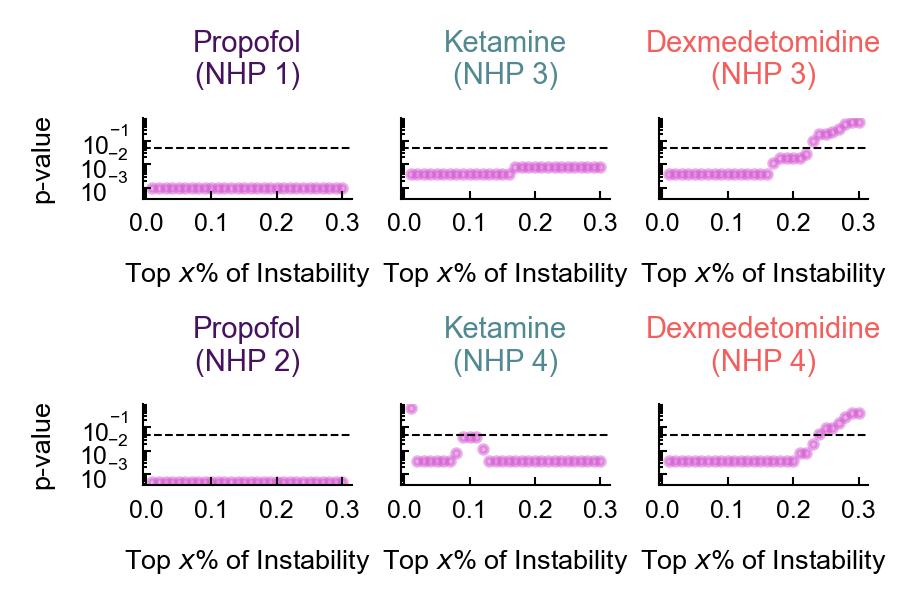

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(3, 2), sharey=True)

max_top_percent = max(top_percents)
plot_top_percents = np.array(top_percents)[np.array(top_percents) <= max_top_percent]

for i, (data_class, agent) in enumerate(anesthetic_agent_list):
    for j, monkey in enumerate(all_section_means[(data_class, agent)]):
        ax = axs[j, i]
        wp_vals_anesthesia_awake = [wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['anesthesia_awake'] for top_percent in plot_top_percents]
        # wp_vals_emergence_awake = [wilcoxon_p_values[(data_class, agent)][monkey][top_percent]['emergence_awake'] for top_percent in plot_top_percents]
        ax.scatter(plot_top_percents, wp_vals_anesthesia_awake, color=cfg.plotting.epoch_colors['anesthesia'], alpha=0.5)
        # ax.scatter(plot_top_percents, wp_vals_emergence_awake, color=cfg.plotting.epoch_colors['emergence'], alpha=0.5)
        ax.axhline(y=0.05, color='black', linestyle='--')
        ax.set_yscale('log')
        NHP_num = j+1 if agent == 'propofol' else j+3
        ax.set_title(f"{agent.capitalize()}\n(NHP {NHP_num})", color=cfg.plotting.curve_colors[agent], fontsize=7)
        ax.set_xlabel(f'Top $x$% of Instability')
        ax.set_xticks([0, 0.1, 0.2, 0.3])
        if i == 0:
            ax.set_ylabel(f'p-value')
anes_pts = plt.scatter([], [], label='Anesthesia-Awake', color=cfg.plotting.epoch_colors['anesthesia'])
# emerg_pts = plt.scatter([], [], label='Emergence-Awake', color=cfg.plotting.epoch_colors['emergence'])

# put legend under figure centered
# fig.legend(ncol=2, bbox_to_anchor=(0.52, -0.02), loc='center')
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'supp', 'stability-wilcoxon-across-top-percent.pdf'), transparent=True, bbox_inches='tight')
plt.show()


# Distribution of stability parameters

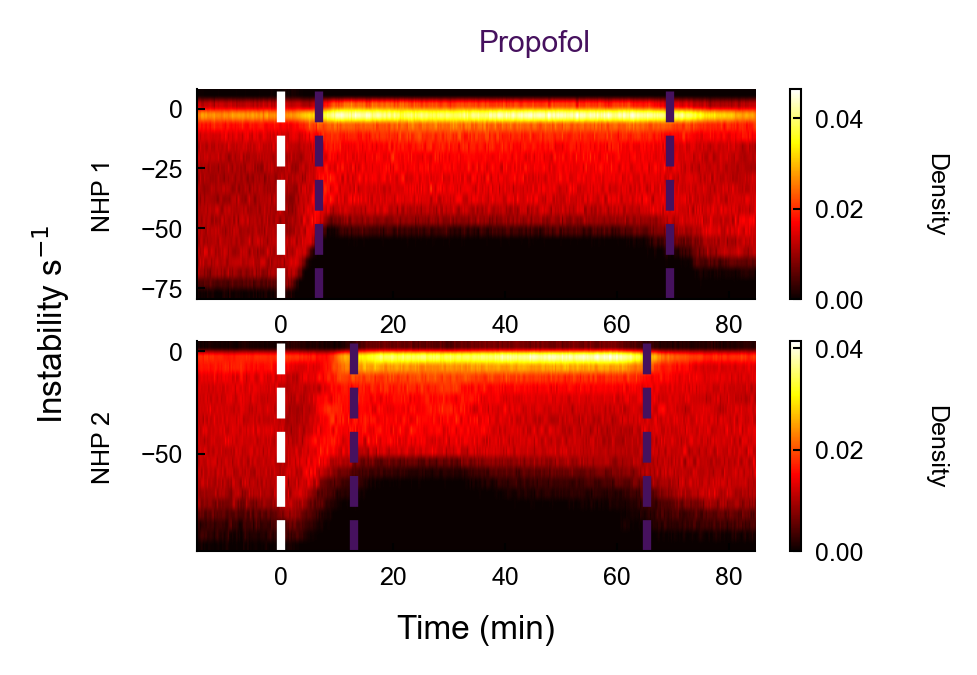

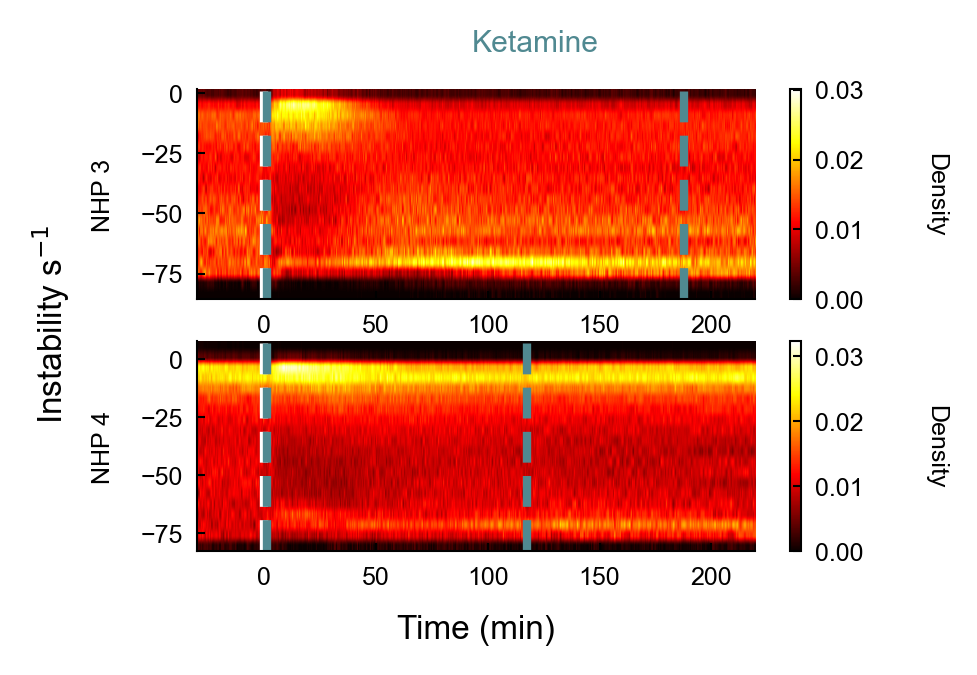

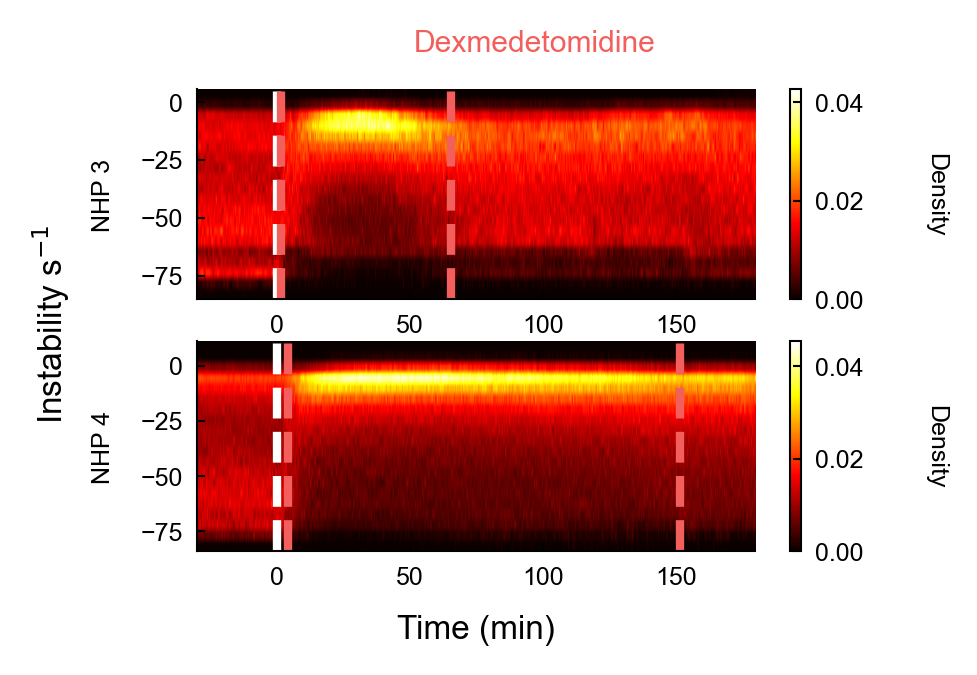

In [ ]:
top_percent = 0.1
for data_class, agent in anesthetic_agent_list:
    if agent == 'propofol':
        plot_range = (-15, 85)
    elif agent == 'ketamine':
        plot_range = (-30, 220)
    else:
        plot_range = (-30, 180)
    cfg.params.data_class = data_class
    common_times = np.arange(plot_range[0], plot_range[1], 1/4)
    all_interpolated_stability_params = {
        monkey: np.zeros((len(common_times), 0)) for monkey in agent_data[(data_class, agent)]['session_lists']
    }
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        
        for session in agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            df = agent_data[(data_class, agent)]['delase_results'][session]['all']
            if 'propofol' in agent:
                is_lever = False
            else:
                is_lever = True
            if is_lever:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', f"{session}.mat"))
                infusion_time = session_file['sessionInfo']['infusionStart'][0, 0]
            else:
                session_file = h5py.File(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class, f"{session}.mat"))
                infusion_time = session_file['sessionInfo']['drugStart'][0]


            time_vals = (df.window_start.values - infusion_time) / 60
            num_eigs = df.stability_params.apply(lambda x: len(x[:int(top_percent*len(x))])).min()
            stability_params = np.vstack(df.stability_params.apply(lambda x: x[:num_eigs]).to_numpy())
            interpolated_stability_params = np.zeros((len(common_times), stability_params.shape[-1]))
            for i in range (stability_params.shape[-1]):
                interpolated_stability_params[:, i] = np.interp(common_times, time_vals, stability_params[:, i])
            all_interpolated_stability_params[monkey] = np.concatenate((all_interpolated_stability_params[monkey], interpolated_stability_params), axis=1)
    
    fig, axs = plt.subplots(2, 1, figsize=(3, 2))

    for i, monkey in enumerate(all_interpolated_stability_params):
        ax = axs[i]
        # 1. Find the global min and max of the stability parameters to define bin edges.
        min_val = np.min(all_interpolated_stability_params[monkey])
        max_val = np.max(all_interpolated_stability_params[monkey])

        # 2. Construct 20 histogram bins between the min and max values.
        num_bins = 20
        bins = np.linspace(min_val, max_val, num_bins + 1)

        # 3. Initialize an array to hold the histogram data for each time point.
        # The shape will be (number of time points, number of bins).
        histogram_data = np.zeros((len(common_times), num_bins))

        # 4. For each time point, compute the histogram of stability parameters.
        for t in range(len(common_times)):
            # Get all stability parameters at the current time point.
            params_at_t = all_interpolated_stability_params[monkey][t, :]
            # Compute the histogram. 'density=True' normalizes it to form a probability density.
            hist, _ = np.histogram(params_at_t, bins=bins, density=True)
            histogram_data[t, :] = hist

        # Use imshow to create the heatmap.
        # - Transpose histogram_data (.T) so time is on the x-axis.
        # - aspect='auto' allows the heatmap to fill the plot area.
        # - origin='lower' places the (0,0) index at the bottom-left.
        # - extent sets the coordinates of the heatmap image.
        # - cmap='hot' matches the color scheme of your example image.
        im = ax.imshow(
            histogram_data.T,
            aspect='auto',
            origin='lower',
            extent=[common_times[0], common_times[-1], min_val, max_val],
            cmap='hot'
        )

        # 6. Add a colorbar and axis labels.
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Density', rotation=270, labelpad=20, fontsize=6)
        ax.set_xlabel('Time (min)', fontsize=8)
        if is_lever:
            ax.set_ylabel(f'NHP {i+3}', fontsize=6)
        else:
            ax.set_ylabel(f'NHP {i+1}', fontsize=6)

        # 7. Set the y-axis ticks and limits to match your example plot.
        # The values are taken directly from the image you provided.
        # y_ticks_values = [-70.2, -53.8, -37.5, -21.2, -4.9, 11.4]
        # ax.set_yticks(y_ticks_values)
        # ax.set_ylim(bottom=y_ticks_values[0], top=y_ticks_values[-1])
        ax.tick_params(axis='both', which='major', labelsize=6)

        # 8. (Optional) Add vertical lines for specific events if you have the times.
        # The colors are chosen to approximate those in your image.
        # Replace the placeholder values (e.g., 2, 8, 60, 75) with your actual event times.
        ax.axvline(x=0, color='white', linestyle='--', linewidth=2)  # Pinkish
        ax.axvline(x=np.mean(agent_data[(data_class, agent)]['locs'][monkey]['high'])/60, color=cfg.plotting.curve_colors[agent], linestyle='--', linewidth=2)
        ax.axvline(x=np.mean(agent_data[(data_class, agent)]['rocs'][monkey]['high'])/60, color=cfg.plotting.curve_colors[agent], linestyle='--', linewidth=2)
    # add text to the left indicating the y axis is "Instability s^{-1}"
    ax.text(-0.3, 0.65, r'Instability s$^{-1}$', rotation=90, fontsize=8, transform=ax.transAxes)
    plt.suptitle(f"{agent.capitalize()}", color=cfg.plotting.curve_colors[agent])
    plt.savefig(os.path.join(img_save_dir, f"{agent}_stability_heatmap.pdf"), transparent=True, bbox_inches='tight')
    plt.show()

# Hyperparameter combos

In [127]:
for (data_class, agent) in anesthetic_agent_list:
    cfg.params.data_class = data_class
    session_list = agent_data[(data_class, agent)]['session_list']
    session_list = [session_list[-1]]
    session = session_list[0]
    section_info, _, _, _ = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    areas = ['all']
    pca_chosen = None
    verbose = False
    grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen, verbose=verbose)
    print(f"Number of models fit for {agent}: {(~np.isnan(grid_search_results[session]['all']['mats']['aic']))[0].sum()} ({grid_search_results[session]['all']['mats']['aic'].shape[0]} windows)")


Number of models fit for propofol: 814 (20 windows)
Number of models fit for ketamine: 630 (32 windows)
Number of models fit for dexmedetomidine: 654 (32 windows)
